# Đồ án 2

#### Cài các thư viện

In [1]:
pip install cluster

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from numpy import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
from scipy import constants
from scipy import stats
import datetime
import binance
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from statsmodels.tsa.stattools import adfuller
import cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize

#### Phần I. Lấy dữ liệu về từ trang web của binance

1) Cài đặt API

In [3]:
API_Key = 'kBQJEBhpuFv5XcCOqbYJYr3CXIfX8pPLiMMMcO1AYYviWm7cuS11G8yCR1OpABXh'
Secret_Key = 'Z7LTEFb4gkDWK9IVCRkpk1M1Gjkwszy7OAH8F5Xvxtoh4HCh28izsQuxGnuK83PO'

In [4]:
client = Client(API_Key, Secret_Key)

2. Tạo hàm lấy dữ liệu của từng đồng Coin từ Binance

In [5]:
def c(symbol): # c mean crawl data
    ticker = symbol + 'USDT'
    historical = client.get_historical_klines(ticker, Client.KLINE_INTERVAL_1DAY, '14 Sep 2020')
    his_df = pd.DataFrame(data = historical)
    his_df = his_df[[4,6]]
    his_df.columns = [symbol,'Close day']
    his_df[symbol] = pd.to_numeric(his_df[symbol])
    #his_df['Close day'] = pd.to_datetime(his_df['Close day']/1kkk, unit='s') #.dt.date
    his_df = his_df[['Close day',symbol]]
    return his_df



3. List các đồng Coin có vốn hoá lớn hơn 1 tỷ $ và liên kết giá của chúng thành 1 ma trận

In [6]:
coin_list = ['BTC','ETH','BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TRX', 'DOT', 'MATIC', 'LTC', 'SHIB', 'WBTC', 'BCH', 'XLM', 
'AVAX', 'LINK', 'XMR', 'UNI', 'ATOM', 'ETC', 'HBAR', 'FIL', 'LDO', 'ICP', 'APT', 'VET', 'MKR', 'QNT', 'OP', 'NEAR', 'ARB']
merged_df = c('BTC')
for i in range(len(coin_list)-1):
    merged_df = pd.merge(merged_df, c(coin_list[i+1]), on='Close day', how='left')

4. Loại bỏ các đồng Coin chưa tồn tại lâu (ít hơn 3 năm) có được ma trận A

In [7]:
merged_df = merged_df.dropna(axis=1)
A = merged_df
A.head()

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,LTC,BCH,XLM,LINK,ATOM,ETC,HBAR,VET,MKR
0,1600127999999,10671.77,377.12,31.2523,0.24564,0.09663,0.002785,3.2641,0.03039,5.3555,0.02009,49.08,225.83,0.08021,12.1374,5.381,5.1494,0.03741,0.012861,486.31
1,1600214399999,10785.31,364.06,27.1181,0.24331,0.09313,0.002828,2.9295,0.02788,5.0535,0.02045,48.31,235.19,0.07778,10.9314,4.866,5.1688,0.03600,0.012569,453.63
2,1600300799999,10954.01,365.11,27.8695,0.24686,0.09151,0.002805,2.5327,0.02639,5.0712,0.01981,47.76,230.85,0.07999,10.7367,5.122,5.1179,0.03619,0.012460,474.66
3,1600387199999,10939.99,389.36,27.0950,0.25214,0.09408,0.002808,2.8829,0.02813,5.3354,0.02044,48.85,232.91,0.08043,11.0139,5.062,5.2043,0.03466,0.013514,502.33
4,1600473599999,10933.39,384.39,27.6290,0.25065,0.09093,0.002789,3.1144,0.02905,5.2616,0.02103,48.54,234.00,0.07825,10.0940,4.966,5.1854,0.03449,0.014430,499.37


Còn lại 19 đồng Coin được sử dụng để sử dụng

#### Phần II. Lựa chọn các đồng Coin phù hợp

1. Xây dựng ma trận tỷ suất lợi nhuận theo ngày X

In [8]:
A_array = np.array(A)
A_array = np.delete(A_array, 0, axis = 1)

In [9]:
X_array = np.empty((A_array.shape[0],A_array.shape[1]), dtype = float)

In [10]:
for i in range(A_array.shape[1]):
    X_array[0,i] = 0

for i in range(A_array.shape[1]):
    for k in range(A_array.shape[0]-1):
        X_array[k+1,i] = (A_array[k+1,i] - A_array[k,i])/A_array[k,i]

In [11]:
X_array_new = np.concatenate((np.array(A[['Close day']]), X_array), axis = 1)

In [12]:
X = pd.DataFrame(X_array_new)
X.columns = A.columns
X['Close day'] = pd.to_datetime(X['Close day']/1000, unit='s').dt.date
X.head(5)

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,LTC,BCH,XLM,LINK,ATOM,ETC,HBAR,VET,MKR
0,2020-09-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-09-15,0.010639,-0.034631,-0.132285,-0.009485,-0.036221,0.015332,-0.102509,-0.082593,-0.056391,0.017919,-0.015689,0.041447,-0.030295,-0.099362,-0.095707,0.003767,-0.037690,-0.022704,-0.067200
2,2020-09-16,0.015642,0.002884,0.027708,0.014590,-0.017395,-0.007957,-0.135450,-0.053443,0.003503,-0.031296,-0.011385,-0.018453,0.028413,-0.017811,0.052610,-0.009848,0.005278,-0.008672,0.046359
3,2020-09-17,-0.001280,0.066418,-0.027790,0.021389,0.028084,0.000891,0.138271,0.065934,0.052098,0.031802,0.022822,0.008924,0.005501,0.025818,-0.011714,0.016882,-0.042277,0.084591,0.058294
4,2020-09-18,-0.000603,-0.012765,0.019708,-0.005909,-0.033482,-0.006624,0.080301,0.032705,-0.013832,0.028865,-0.006346,0.004680,-0.027104,-0.083522,-0.018965,-0.003632,-0.004905,0.067782,-0.005893


2. Kiểm định tính dừng

In [13]:
new_coin_list = X.columns.tolist()
for i in range(len(new_coin_list)-1):
    p = adfuller(X[new_coin_list[i+1]])[1]
    print(new_coin_list[i+1], ':', p)
    if p > 0.05:
        print(new_coin_list[i+1], 'không thoả mãn tính chất dừng')

BTC : 0.0
ETH : 2.107527931075194e-19
BNB : 1.4579581944252065e-13
XRP : 0.0


ADA : 4.631968784472237e-19
DOGE : 0.0
SOL : 1.27659740247347e-16
TRX : 2.480941448023871e-14
DOT : 9.074430968216482e-22
MATIC : 1.1154928978661232e-05
LTC : 0.0
BCH : 2.405436008594896e-11
XLM : 0.0
LINK : 1.0871197910345884e-22
ATOM : 2.0129868560828936e-21
ETC : 1.751690843095744e-09
HBAR : 1.334550064458505e-29
VET : 1.9433512750642978e-23
MKR : 1.0504328463160005e-25


Vậy các đồng Coin đều thoả mãn tính dừng

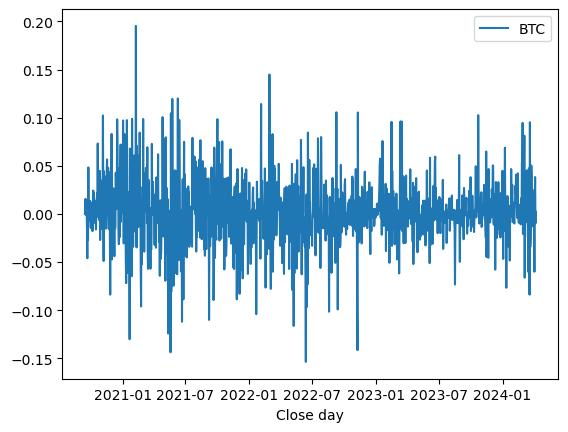

In [14]:
X.plot(x= 'Close day', y = 'BTC')
plt.show()

3. Kiểm định phân phối nặng đuôi

In [15]:
result_arr = np.empty((4,X_array.shape[1]), dtype = float)
pk = 0.005
for i in range(len(new_coin_list)-1):
    n = 0 # negative
    p = 0 # positive
    h = X[new_coin_list[i+1]].mean() + 3*X[[new_coin_list[i+1]]].std() #head
    h = float(h)
    t = X[new_coin_list[i+1]].mean() - 3*X[new_coin_list[i+1]].std() #tail
    t = float(t)
    for k in range(X.shape[0]-1):
        if X_array[k+1,i] > h:  
            p = p + 1
        if X_array[k+1,i] < t:
            n = n + 1
    p1 = n/X.shape[0]
    result_arr[0,i] = float(p1)*100
    result_arr[1,i] = int(p - n)
    result_arr[2,i] = X[new_coin_list[i+1]].mean()
    result_arr[3,i] = X[new_coin_list[i+1]].std()
    

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10820\1599311237.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  h = float(h)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10820\1599311237.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  h = float(h)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10820\1599311237.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  h = float(h)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10820\1599311237.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  h = float(h)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10820\1599311237.py:7: FutureWarning: Calling float on a

In [16]:
index = [['p1 (%)'], ['p-n'], ['mean'], ['std']]

In [17]:
result_arr_new =  np.concatenate((index, result_arr), axis = 1)


In [18]:
result_df = pd.DataFrame(result_arr_new)
result_df.columns = new_coin_list
result_df = result_df.rename(columns={'Close day': 'Index'})
result_df


,Index,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,LTC,BCH,XLM,LINK,ATOM,ETC,HBAR,VET,MKR
0,p1 (%),0.9223674096848578,0.7686395080707148,0.6149116064565718,0.4611837048424289,0.3843197540353574,0.0,0.4611837048424289,0.8455034588777863,0.4611837048424289,0.3074558032282859,0.7686395080707148,0.4611837048424289,0.3843197540353574,0.5380476556495004,0.6149116064565718,0.4611837048424289,0.23059185242121444,0.4611837048424289,0.3074558032282859
1,p-n,-3.0,-2.0,7.0,11.0,17.0,6.0,8.0,7.0,8.0,15.0,3.0,8.0,9.0,1.0,7.0,13.0,10.0,8.0,10.0
2,mean,0.001984980834104908,0.0026106436497334152,0.003441679487324772,0.002466210037776634,0.002729235462428103,0.007487465562174294,0.005350035623099709,0.001994585198703662,0.00188313433954864,0.005307500231995779,0.0017407309359405944,0.0023270775342070374,0.0018502702693782827,0.001855112509491446,0.002375132919256984,0.003124386112339458,0.0024738083451162716,0.0025973254988042906,0.0031029937482669133
3,std,0.033521596618546264,0.04317347376865662,0.05017729337237938,0.061995391990611645,0.05255642801423656,0.13193537035647374,0.0677135724609169,0.043876411775424326,0.0557184047757966,0.07168810442608882,0.04884231890429771,0.055623440841903654,0.05699479612717826,0.05601990570913363,0.06061278690427633,0.05968833364466046,0.05911640845799726,0.0588305783760152,0.057237265522529265


In [19]:
mark = np.empty((result_arr.shape[0]+1, result_arr.shape[1]), dtype = int)
w_p1 = 0.4
w_pn = 0.2
w_mean = 0.2
w_std = 0.2

In [20]:
result_arr_IQR = result_arr
for i in range (result_arr.shape[1]):
    result_arr_IQR[0,i] = - result_arr[0,i]
    result_arr_IQR[3,i] = - result_arr[3,i]

In [21]:
for k in range(4):
    q1 = np.percentile(result_arr_IQR[k], 25)
    q2 = np.percentile(result_arr_IQR[k], 50)
    q3 = np.percentile(result_arr_IQR[k], 75)
    for i in range(result_arr.shape[1]):
        if result_arr_IQR[k,i] < q1:
            mark[k,i] = 1
        elif result_arr_IQR[k,i] > q1 and result_arr_IQR[k,i] < q2:
            mark[k,i] = 2
        elif result_arr_IQR[k,i] > q2 and result_arr_IQR[k,i] < q3:
            mark[k,i] = 3
        else:
            mark[k,i] = 4

In [22]:

for i in range(result_arr.shape[1]):
    mark[4,i] = mark[0,i] * w_p1 + mark[1,i] * w_pn + mark[2,i] * w_mean + mark[3,i] * w_std

In [23]:
temp = [['Total mark']]
index_new = np.concatenate((index, temp), axis = 0)

In [24]:
mark_new =  np.concatenate((index_new, mark), axis = 1)
mark_df = pd.DataFrame(mark_new)
mark_df.columns = new_coin_list
mark_df = mark_df.rename(columns={'Close day': 'Index'})
mark_df

,Index,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,LTC,BCH,XLM,LINK,ATOM,ETC,HBAR,VET,MKR
0,p1 (%),1,1,4,4,4,4,4,1,4,4,1,4,4,2,4,4,4,4,4
1,p-n,1,1,2,4,4,1,4,2,4,4,1,4,3,1,2,4,4,4,4
2,mean,1,3,4,2,3,4,4,2,1,4,1,2,1,1,2,4,4,3,3
3,std,4,4,4,1,3,1,1,4,3,1,4,3,4,3,1,2,2,2,2
4,Total mark,1,2,3,3,3,2,3,2,3,3,1,3,3,1,2,3,3,3,3


In [25]:
temp_list = new_coin_list[1:]

In [26]:
drop_list = []
q1_mark = np.percentile(mark[4], 25)
for i in range(result_arr.shape[1]):
    if mark[4,i] < q1_mark and temp_list[i] != 'BTC' and temp_list[i] != 'ETH':
        print('Loại đồng coin:', temp_list[i])
        drop_list.append(temp_list[i])
        
    

Loại đồng coin: LTC
Loại đồng coin: LINK


In [27]:
final_df = X.drop(columns = drop_list)
final_df.tail(5)

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,BCH,XLM,ATOM,ETC,HBAR,VET,MKR
1296,2024-04-02,-0.060098,-0.064170,-0.042376,-0.041899,-0.065196,-0.109984,-0.055712,-0.032279,-0.061358,-0.053113,-0.013280,-0.050923,-0.057008,-0.082619,-0.057325,-0.074684,0.002672
1297,2024-04-03,0.007627,0.009720,0.018317,-0.019132,-0.019631,-0.039785,0.019391,0.004287,-0.019343,-0.005887,-0.072300,-0.017885,-0.012948,0.022015,-0.010618,-0.004877,0.010928
1298,2024-04-04,0.038271,0.005005,0.042743,0.033612,0.024240,0.027166,-0.005674,0.017333,0.008317,0.011732,0.122470,0.020586,0.017275,0.071802,0.026341,0.023769,0.042447
1299,2024-04-05,-0.009741,-0.002870,-0.013151,-0.010783,-0.015435,-0.015446,-0.052337,-0.010491,-0.012609,-0.023854,-0.012173,-0.010861,-0.010806,0.007917,-0.005703,-0.034466,-0.067527
1300,2024-04-06,0.002155,0.005633,0.005365,0.005280,0.011670,0.028160,0.016803,0.000000,0.007280,0.015499,0.045489,0.008627,0.010465,-0.006949,0.005736,0.006693,0.006781


#### Phần III: Xây dựng mô hình đầu tư trực tuyến

1. Xây dựng ma trận giá tương đối

In [28]:
A = A.drop(columns = drop_list)

In [29]:
A

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,BCH,XLM,ATOM,ETC,HBAR,VET,MKR
0,1600127999999,10671.77,377.12,31.2523,0.24564,0.09663,0.002785,3.2641,0.03039,5.3555,0.02009,225.83,0.08021,5.381,5.1494,0.03741,0.012861,486.31
1,1600214399999,10785.31,364.06,27.1181,0.24331,0.09313,0.002828,2.9295,0.02788,5.0535,0.02045,235.19,0.07778,4.866,5.1688,0.03600,0.012569,453.63
2,1600300799999,10954.01,365.11,27.8695,0.24686,0.09151,0.002805,2.5327,0.02639,5.0712,0.01981,230.85,0.07999,5.122,5.1179,0.03619,0.012460,474.66
3,1600387199999,10939.99,389.36,27.0950,0.25214,0.09408,0.002808,2.8829,0.02813,5.3354,0.02044,232.91,0.08043,5.062,5.2043,0.03466,0.013514,502.33
4,1600473599999,10933.39,384.39,27.6290,0.25065,0.09093,0.002789,3.1144,0.02905,5.2616,0.02103,234.00,0.07825,4.966,5.1854,0.03449,0.014430,499.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,1712102399999,65463.99,3278.96,551.4000,0.58540,0.58070,0.182480,181.5300,0.11662,8.5820,0.90030,639.00,0.12860,10.967,29.9800,0.10360,0.041010,3752.00
1297,1712188799999,65963.28,3310.83,561.5000,0.57420,0.56930,0.175220,185.0500,0.11712,8.4160,0.89500,592.80,0.12630,10.825,30.6400,0.10250,0.040810,3793.00
1298,1712275199999,68487.79,3327.40,585.5000,0.59350,0.58310,0.179980,184.0000,0.11915,8.4860,0.90550,665.40,0.12890,11.012,32.8400,0.10520,0.041780,3954.00
1299,1712361599999,67820.62,3317.85,577.8000,0.58710,0.57410,0.177200,174.3700,0.11790,8.3790,0.88390,657.30,0.12750,10.893,33.1000,0.10460,0.040340,3687.00


In [30]:
A_array = np.array(A)
A_array = np.delete(A_array, 0, axis = 1)
X_array = np.empty((A_array.shape[0],A_array.shape[1]), dtype = float)
for i in range(A_array.shape[1]):
    X_array[0,i] = 0

for i in range(A_array.shape[1]):
    for k in range(A_array.shape[0]-1):
        X_array[k+1,i] = (A_array[k+1,i])/A_array[k,i]
X_array_new = np.concatenate((np.array(A[['Close day']]), X_array), axis = 1)
X = pd.DataFrame(X_array_new)
X.columns = A.columns
X['Close day'] = pd.to_datetime(X['Close day']/1000, unit='s').dt.date
X[:5]

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,BCH,XLM,ATOM,ETC,HBAR,VET,MKR
0,2020-09-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-09-15,1.010639,0.965369,0.867715,0.990515,0.963779,1.015332,0.897491,0.917407,0.943609,1.017919,1.041447,0.969705,0.904293,1.003767,0.962310,0.977296,0.932800
2,2020-09-16,1.015642,1.002884,1.027708,1.014590,0.982605,0.992043,0.864550,0.946557,1.003503,0.968704,0.981547,1.028413,1.052610,0.990152,1.005278,0.991328,1.046359
3,2020-09-17,0.998720,1.066418,0.972210,1.021389,1.028084,1.000891,1.138271,1.065934,1.052098,1.031802,1.008924,1.005501,0.988286,1.016882,0.957723,1.084591,1.058294
4,2020-09-18,0.999397,0.987235,1.019708,0.994091,0.966518,0.993376,1.080301,1.032705,0.986168,1.028865,1.004680,0.972896,0.981035,0.996368,0.995095,1.067782,0.994107


2. Sử dụng thuật toán phân cụm _K-means_ dự đoán giá tương lai của đồng Coin

In [31]:
X_arr = np.array(X)
X_arr = np.delete(X_arr, 0, axis = 1)
X_arr = np.delete(X_arr, 0, axis = 0)

In [32]:
K = 1
I = 1

In [33]:
"""
best_n = 0
best_silhouette = 0
best_TW = 0
for TW in range(2,9):
    array_3d = np.zeros((X_arr.shape[0] - TW + 1, TW, X_arr.shape[1]))
    for i in range(X_arr.shape[0] - TW + 1):
        for j in range(TW):
            for k in range(X_arr.shape[1]):
                array_3d[i,j,k] = X_arr[i+j,k]

    vector_arr = np.empty((0, TW * X_arr.shape[1]), dtype=float)
    for i in range(X_arr.shape[0] - TW + 1):
        vector_arr = np.insert(vector_arr, i, array_3d[i].flatten(), axis=0)

    silhouette_max = 0
    n_max = 0
    for i in range(2,K+2):
        silhouette_avg = 0
        n_clusters = i
        kmeans = KMeans(n_clusters)
        for k in range(I):
            kmeans.fit(vector_arr)
            silhouette_I = silhouette_score(vector_arr, kmeans.labels_)
            silhouette_avg = silhouette_avg + silhouette_I
        silhouette_avg = silhouette_avg/I
        if silhouette_avg > silhouette_max:
            silhouette_max = silhouette_avg
            n_max = i 
        
    if silhouette_max > best_silhouette:
        best_n = n_max
        best_silhouette = silhouette_max
        best_TW = TW
"""

'\nbest_n = 0\nbest_silhouette = 0\nbest_TW = 0\nfor TW in range(2,9):\n    array_3d = np.zeros((X_arr.shape[0] - TW + 1, TW, X_arr.shape[1]))\n    for i in range(X_arr.shape[0] - TW + 1):\n        for j in range(TW):\n            for k in range(X_arr.shape[1]):\n                array_3d[i,j,k] = X_arr[i+j,k]\n\n    vector_arr = np.empty((0, TW * X_arr.shape[1]), dtype=float)\n    for i in range(X_arr.shape[0] - TW + 1):\n        vector_arr = np.insert(vector_arr, i, array_3d[i].flatten(), axis=0)\n\n    silhouette_max = 0\n    n_max = 0\n    for i in range(2,K+2):\n        silhouette_avg = 0\n        n_clusters = i\n        kmeans = KMeans(n_clusters)\n        for k in range(I):\n            kmeans.fit(vector_arr)\n            silhouette_I = silhouette_score(vector_arr, kmeans.labels_)\n            silhouette_avg = silhouette_avg + silhouette_I\n        silhouette_avg = silhouette_avg/I\n        if silhouette_avg > silhouette_max:\n            silhouette_max = silhouette_avg\n        

In [34]:
TW = 3

In [35]:

array_3d = np.zeros((X_arr.shape[0] - TW + 1, TW, X_arr.shape[1]))
for i in range(X_arr.shape[0] - TW + 1):
    for j in range(TW):
        for k in range(X_arr.shape[1]):
            array_3d[i,j,k] = X_arr[i+j,k]

In [36]:
vector_arr = np.empty((0, TW * X_arr.shape[1]), dtype=float)
for i in range(X_arr.shape[0] - TW + 1):
    vector_arr = np.insert(vector_arr, i, array_3d[i].flatten(), axis=0)

In [37]:
silhouette_max = 0
n_max = 0
for i in range(2,K+2):
    silhouette_avg = 0
    n_clusters = i
    kmeans = KMeans(n_clusters)
    for k in range(I):
        kmeans.fit(vector_arr)
        silhouette_I = silhouette_score(vector_arr, kmeans.labels_)
        silhouette_avg = silhouette_avg + silhouette_I
    silhouette_avg = silhouette_avg/I
    if silhouette_avg > silhouette_max:
        silhouette_max = silhouette_avg
        n_max = i 
print("Với TW = {}, chọn số chia thành {} cụm là tối ưu nhất, Silhouette = {}".format(TW, n_max, silhouette_max))
n_clusters = n_max

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Với TW = 3, chọn số chia thành 2 cụm là tối ưu nhất, Silhouette = 0.109772113391746


In [38]:
I = 1 # Tăng I nhằm tăng độ chính xác
cluster_arr = np.empty((0, X_arr.shape[0] - TW + 1), dtype=int)
kmeans = KMeans(n_clusters)
for i in range(I):
    kmeans.fit(vector_arr)
    silhouette_avg = silhouette_score(vector_arr, kmeans.labels_)
    label = kmeans.labels_
    cluster_arr = np.insert(cluster_arr, i, label, axis=0)
cluster_arr = cluster_arr.T

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [39]:
# Vector ma trận giá tương đối của hiện tại :cluster_arr[cluster_arr.shape[0]-1] 
same_list = []
for k in range(cluster_arr.shape[0] - 1):
    same = 0
    for i in range(I):
        if cluster_arr[cluster_arr.shape[0]-1, i] == cluster_arr[k,i]:
            same = same + 1
    if same/I >= 0.8:
        same_list.append(k)

print('Có',len(same_list),'ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại')

Có 596 ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại


In [40]:
cos_list = [] # Vector độ tương tự cosin
for i in same_list:
    cosP = np.dot(cluster_arr[cluster_arr.shape[0]-1], cluster_arr[i])/(np.linalg.norm(cluster_arr[cluster_arr.shape[0]-1])*np.linalg.norm(cluster_arr[i]))
    cos_list.append(cosP)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10820\2222077076.py:3: RuntimeWarning: invalid value encountered in scalar divide
  cosP = np.dot(cluster_arr[cluster_arr.shape[0]-1], cluster_arr[i])/(np.linalg.norm(cluster_arr[cluster_arr.shape[0]-1])*np.linalg.norm(cluster_arr[i]))


In [41]:
W = [] # Vector trọng số
for i in range(len(cos_list)):
    w_i = cos_list[i]/sum(cos_list)
    W.append(w_i)

In [42]:
W = np.array(W)
W = W.reshape(1,len(same_list))

In [43]:
C_arr = np.empty((0, X_arr.shape[1]), dtype=float)
k = 0
for i in same_list:
    C_arr = np.insert(C_arr, k, X_arr[i+TW], axis=0)
    k = k+1

In [44]:
predict_arr = np.dot(W,C_arr)
temp = np.append(datetime.date.today() + datetime.timedelta(days=1),predict_arr)
predict_df = pd.DataFrame(temp).transpose()
predict_df.columns = A.columns
predict_df

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,BCH,XLM,ATOM,ETC,HBAR,VET,MKR
0,2024-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
R = predict_arr - 1
temp = np.append(datetime.date.today() + datetime.timedelta(days=1),R)
R_df = pd.DataFrame(temp).transpose()
R_df.columns = A.columns
R_df

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,BCH,XLM,ATOM,ETC,HBAR,VET,MKR
0,2024-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
temp_list = A.columns[1:]
drop_list = []
temp_list = A.columns[1:]
for i in range(R.shape[1]):
    if R[0,i] <= 0:
        drop_list.append(temp_list[i])
R_df_final = R_df.drop(columns = drop_list)
R_df_final

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,MATIC,BCH,XLM,ATOM,ETC,HBAR,VET,MKR
0,2024-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. Phân bổ vốn cho các Crypto


In [47]:
R_arr = np.array(R_df_final)
R_arr = np.delete(R_arr, 0, axis = 1)

In [48]:
sum_R = 0
for i in range(R_arr.shape[1]):
    sum_R = sum_R + R_arr[0,i]
B = [] # Vector trọng số
for i in range(R_arr.shape[1]):
    w_i = R_arr[0,i]/sum_R
    B.append(w_i)

In [49]:
B_arr = np.array(B)
B_arr = B_arr.reshape(1,R_arr.shape[1])
Profit = np.dot(B_arr,R_arr.T)
print("Dự đoán tỷ suất lợi nhuận của ngày hôm nay: {} %".format(round(float(Profit) * 100,3)))

Dự đoán tỷ suất lợi nhuận của ngày hôm nay: nan %


#### Phần IV. Kiểm thử hiệu quả mô hình với dữ liệu trong quá khứ

1. Thị trường Bull


In [50]:

def c(symbol): # c mean crawl data
    ticker = symbol + 'USDT'
    historical = client.get_historical_klines(ticker, Client.KLINE_INTERVAL_1DAY, '22 Jul 2022') 
    #14 Jun 2019 test 180
    #14 Mar 2020 test 180
    #9 Nov 2018 test 180
    his_df = pd.DataFrame(data = historical)
    his_df = his_df[[4,6]]
    his_df.columns = [symbol,'Close day']
    his_df[symbol] = pd.to_numeric(his_df[symbol])
    #his_df['Close day'] = pd.to_datetime(his_df['Close day']/1kkk, unit='s') #.dt.date
    his_df = his_df[['Close day',symbol]]
    return his_df

In [51]:
coin_list = ['BTC','ETH','BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TRX', 'DOT', 'MATIC', 'SHIB', 'WBTC', 'BCH', 'XLM', 
'AVAX', 'XMR', 'UNI', 'ETC', 'HBAR', 'FIL', 'LDO', 'ICP', 'APT', 'VET', 'MKR', 'QNT', 'OP', 'NEAR', 'ARB']
merged_df = c('BTC')
for i in range(len(coin_list)-1):
    merged_df = pd.merge(merged_df, c(coin_list[i+1]), on='Close day', how='left')

In [52]:
merged_df = merged_df.dropna(axis=1)
A_test = merged_df
display(A_test)

,Close day,BTC,ETH,BNB,XRP,ADA,DOGE,SOL,TRX,DOT,...,ETC,HBAR,FIL,LDO,ICP,VET,MKR,QNT,OP,NEAR
0,1658534399999,22684.83,1535.27,262.4,0.3578,0.4828,0.06743,40.54,0.06700,7.290,...,24.88,0.0694,5.480,1.531,6.480,0.02526,947.0,100.7,0.835,4.321
1,1658620799999,22451.07,1548.67,259.2,0.3592,0.5170,0.06804,39.97,0.06698,7.330,...,25.54,0.0686,5.570,1.580,6.680,0.02502,955.0,100.3,0.940,4.308
2,1658707199999,22579.68,1597.70,261.4,0.3586,0.5120,0.06755,40.93,0.06683,7.400,...,25.53,0.0724,5.640,1.645,6.610,0.02506,986.0,97.6,0.919,4.352
3,1658793599999,21310.90,1440.79,244.6,0.3362,0.4752,0.06193,36.65,0.06369,6.760,...,23.27,0.0651,5.240,1.451,6.220,0.02333,894.0,87.6,0.795,3.787
4,1658879999999,21254.67,1449.12,249.4,0.3372,0.4677,0.06252,36.25,0.06536,6.780,...,25.17,0.0658,5.320,1.445,6.590,0.02332,918.0,92.8,0.827,3.755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,1712102399999,65463.99,3278.96,551.4,0.5854,0.5807,0.18248,181.53,0.11662,8.582,...,29.98,0.1036,8.575,2.597,17.906,0.04101,3752.0,119.4,3.156,6.216
621,1712188799999,65963.28,3310.83,561.5,0.5742,0.5693,0.17522,185.05,0.11712,8.416,...,30.64,0.1025,8.422,2.547,17.833,0.04081,3793.0,118.7,3.052,6.596
622,1712275199999,68487.79,3327.40,585.5,0.5935,0.5831,0.17998,184.00,0.11915,8.486,...,32.84,0.1052,8.633,2.560,17.851,0.04178,3954.0,121.3,3.105,6.727
623,1712361599999,67820.62,3317.85,577.8,0.5871,0.5741,0.17720,174.37,0.11790,8.379,...,33.10,0.1046,8.393,2.610,16.854,0.04034,3687.0,118.5,2.873,7.222


In [53]:
A_arr = A_test.values
#A_arr = np.delete(A_arr, 0, axis = 1)
A_arr.shape[1]

26

In [54]:
TW = 3
K = 4
I = 20
cost_rate = 1.5
p = 0.8

In [55]:
test_day = 120
capital = 1
capital_day = [1]
model_day = 365


In [56]:

length_drop = 0
true = 0
false = 0 
for day in range(test_day): 
    print(day,'************************************************************************')
    day_arr = np.empty((0,A_test.shape[1]),dtype=float)
    for i in range(model_day):
        day_arr = np.insert(day_arr, i, A_arr[i+day], axis=0)
    day_df = pd.DataFrame(day_arr)
    day_df.columns = A_test.columns

    A = day_df
    
    A_array = np.array(A)
    A_array = np.delete(A_array, 0, axis = 1)
    X_array = np.empty((A_array.shape[0],A_array.shape[1]), dtype = float)
    for i in range(A_array.shape[1]):
        X_array[0,i] = 0

    for i in range(A_array.shape[1]):
        for k in range(A_array.shape[0]-1):
            X_array[k+1,i] = (A_array[k+1,i])/A_array[k,i]
    X_array_new = np.concatenate((np.array(A[['Close day']]), X_array), axis = 1)
    X = pd.DataFrame(X_array_new)
    X.columns = A.columns
    X['Close day'] = pd.to_datetime(X['Close day']/1000, unit='s').dt.date
    X[:5]

    X_arr = np.array(X)
    X_arr = np.delete(X_arr, 0, axis = 1)
    X_arr = np.delete(X_arr, 0, axis = 0)


    array_3d = np.zeros((X_arr.shape[0] - TW + 1, TW, X_arr.shape[1]))
    for i in range(X_arr.shape[0] - TW + 1):
        for j in range(TW):
            for k in range(X_arr.shape[1]):
                array_3d[i,j,k] = X_arr[i+j,k]

    
    vector_arr = np.empty((0, TW * X_arr.shape[1]), dtype=float)
    for i in range(X_arr.shape[0] - TW + 1):
        vector_arr = np.insert(vector_arr, i, array_3d[i].flatten(), axis=0)


      
    #I = 50 # Tăng I nhằm tăng độ chính xác
    cluster_arr = np.empty((0, X_arr.shape[0] - TW + 1), dtype=int)
    kmeans = KMeans(K)
    for i in range(I):
        kmeans.fit(vector_arr)
        silhouette_avg = silhouette_score(vector_arr, kmeans.labels_)
        label = kmeans.labels_
        cluster_arr = np.insert(cluster_arr, i, label, axis=0)

    cluster_arr = cluster_arr.T

    same_list = []
    for k in range(cluster_arr.shape[0] - 1):
        same = 0
        for i in range(I):
            if cluster_arr[cluster_arr.shape[0]-1, i] == cluster_arr[k,i]:
                same = same + 1
        if same/I >= p:
            same_list.append(k)


    print('Có',len(same_list),'ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại')

    
    cos_list = [] # Vector độ tương tự cosin
    for i in same_list:
        cosP = float(np.dot(cluster_arr[cluster_arr.shape[0]-1], cluster_arr[i]))/float((np.linalg.norm(cluster_arr[cluster_arr.shape[0]-1])*np.linalg.norm(cluster_arr[i])))
        cos_list.append(cosP)
        print(cosP ,"******")

    
    W = [] # Vector trọng số
    for i in range(len(cos_list)):
        w_i = cos_list[i]/sum(cos_list)
        W.append(w_i)

    
    W = np.array(W)
    W = W.reshape(1,len(same_list))


    
    C_arr = np.empty((0, X_arr.shape[1]), dtype=float)
    k = 0
    for i in same_list:
        C_arr = np.insert(C_arr, k, X_arr[i+TW], axis=0) # Giá tương đối ngay sau đó của các TW
        k = k+1

    
    predict_arr = np.dot(W,C_arr)
    temp = np.append(datetime.date.today() + datetime.timedelta(days=1),predict_arr)
    predict_df = pd.DataFrame(temp).transpose()
    predict_df.columns = A.columns
    predict_df

    
    R = predict_arr - 1
    temp = np.append(datetime.date.today() + datetime.timedelta(days=1),R)
    R_df = pd.DataFrame(temp).transpose()
    R_df.columns = A.columns
    R_df

    
    temp_list = A.columns[1:]
    drop_list = []
    temp_list = A.columns[1:]
    for i in range(R.shape[1]):
        if R[0,i] <= 0:
            drop_list.append(temp_list[i])
            length_drop = length_drop + 1
            
    R_df_final = R_df.drop(columns = drop_list)
    R_df_final

    
    R_arr = np.array(R_df_final)
    R_arr = np.delete(R_arr, 0, axis = 1)

    real_price = A_test.values
    real_price = real_price[day+model_day]/real_price[day+model_day-1] - 1
    R_real_df = pd.DataFrame(real_price).transpose()
    R_real_df.columns = A_test.columns
    R_df_real_final = R_real_df.drop(columns = drop_list)
    R_arr_real = np.array(R_df_real_final)
    R_arr_real = np.delete(R_arr_real, 0, axis = 1)

    for test in range(R_arr.shape[1]):
        if R_arr[0,test] * R_arr_real[0,test] > 0:
            true = true + 1
        else:# R_arr[0,test] > 0 and R_arr_real[0,test] < 0:
            false = false + 1
#TW_good.append('TW:{} true:{} false:{}'.format(TW,true,false))

    #print('Predict:',R_arr)
    #print('Real:',R_arr_real)

    sum_R = 0
    for i in range(R_arr.shape[1]):
        sum_R = sum_R + R_arr[0,i]
    B = [] # Vector trọng số
    for i in range(R_arr.shape[1]):
        w_i = R_arr[0,i]/sum_R
        B.append(w_i)

    B_arr = np.array(B)
    B_arr = B_arr.reshape(1,R_arr.shape[1])
    Profit = np.dot(B_arr,R_arr.T)
    Profit_real = np.dot(B_arr, R_arr_real.T)
    #print("Dự đoán tỷ suất lợi nhuận của ngày hôm nay: {} %".format(round(float(Profit) * 100,3)))
    #print("Tỷ suất lợi nhuận thực tế của ngày hôm nay: {} %".format(round(float(Profit_real) * 100,3)))
    capital = capital*(float((Profit_real)) + 1)*pow(0.999,cost_rate)
    capital_day.append(float(capital))
    #print(day,capital,'************************************************************************')




0 ************************************************************************


c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Có 56 ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại
0.9931326192185401 ******
0.9931326192185401 ******
1.0 ******
0.9197325308962094 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9010239053216177 ******
0.9931326192185401 ******
0.9936145523160511 ******
0.9931326192185401 ******
0.9928377679927978 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.8959216401473294 ******
1.0 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.8785882539782276 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9869682265368204 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.925785694818907 ******
0.9928377679927978 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9869682265368204 ******
0.9869682265368204 ******
0.9869682265368204 ******
0.9931326192185401 ******
0.9931326192185401 ******
0.9931326192185401 ***

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Có 82 ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại
0.9784921095801632 ******
0.8991721961325718 ******
0.9050684704320512 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.9744203145947592 ******
0.9744203145947592 ******
0.9804088442468002 ******
0.8991721961325718 ******
0.962288694926066 ******
0.9949069443293332 ******
0.8991721961325718 ******
0.9949069443293332 ******
0.962288694926066 ******
0.962288694926066 ******
0.9744203145947592 ******
0.9949069443293332 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.9949069443293332 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.9744203145947592 ******
0.8991721961325718 ******
0.8991721961325718 ******
0.9739421345343697 ******
0.9544613238842186 *

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Có 67 ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9463718918526286 ******
0.9463718918526286 ******
0.9594259139147681 ******
0.9697622757528539 ******
0.9594259139147681 ******
0.8623164985025763 ******
0.8581366251553131 ******
0.9463718918526286 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.8581366251553131 ******
0.9594259139147681 ******
0.9639603730060448 ******
0.9594259139147681 ******
0.9672041516493517 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.8623164985025763 ******
0.9594259139147681 ******
0.9463718918526286 ******
0.9639603730060448 ******
0.9463718918526286 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9594259139147681 ******
0.9338366113496058 ******
0.959425913914768

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Có 78 ma trận mà 80% số lần chạy được phân vào cùng với ma trận hiện tại
0.9697622757528538 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9534625892455922 ******
0.9626638889484738 ******
0.9626638889484738 ******
0.9999999999999998 ******
0.929320377284585 ******
0.9999999999999998 ******
0.929320377284585 ******
0.9534625892455922 ******
0.929320377284585 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.929320377284585 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9534625892455922 ******
0.9999999999999998 ******
0.9999999999999998 ******
0.9134333882114983 ******
0.9999999999999998 ******
0.921284663987611 ******
0.929320377284585 ******
0.9999999999999998 ****

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

KeyboardInterrupt: 

In [57]:
temp = pd.DataFrame(capital_day)
temp = temp.values
temp = temp.flatten()
capital_day = temp

In [58]:
day_list = (A_test['Close day']).tolist()
day_list = day_list[model_day -1: model_day + test_day]
day_df = pd.DataFrame(day_list)
day_df.columns = ['Close day']
day_df['Close day']= pd.to_datetime(day_df['Close day']/1000, unit='s').dt.date
day_list = day_df.values

In [ ]:
print("Số vốn sau {} ngày giao dịch tính từ ngày {} tăng trưởng {} %".format(test_day,day_list[1].astype('str'), round(float((capital-1)*100),3)))

Số vốn sau 120 ngày giao dịch tính từ ngày ['2023-07-22'] tăng trưởng -22.441 %


ValueError: x and y must have same first dimension, but have shapes (121, 1) and (5,)

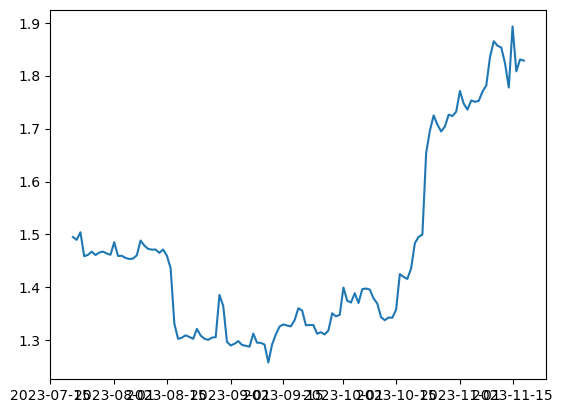

In [59]:
BTC_arr = A_test['BTC'].values
BTC_arr = BTC_arr[model_day -1: model_day + test_day]
BTC_arr = BTC_arr/20000
plt.plot(day_list, BTC_arr)
plt.plot(day_list, capital_day)
#plt.xlabel('Day')
plt.axhline(y=1, color='r', linestyle='--', label='Horizontal Line')
plt.ylabel('Capital')
plt.title('Capital changing per day')
plt.xticks(rotation = 'vertical')


plt.show()


In [ ]:
print('Tăng trưởng trung bình ngày là: {} %'.format((capital_day-1).mean()*100))
print('Độ lệch chuẩn của nguồn vốn là: {} %'.format((capital_day-1).std()*100))

Tăng trưởng trung bình ngày là: -24.821571915770612 %
Độ lệch chuẩn của nguồn vốn là: 9.97930149245923 %


In [ ]:
np.corrcoef(capital_day, BTC_arr)[0,1]

0.31892616965262405